Inspiration from https://medium.com/@olaf.lenzmann/mastering-llms-for-complex-classification-tasks-64f0bda2edf3

There is a high number of false positives. Therefore added a clarification "...only when absolutely sure that the particular bias category is present..."


In [1]:
#val_or_test_split = 'val'
val_or_test_split = 'test'

In [2]:
!pip install -q datasets
!pip install --upgrade openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from datasets import load_dataset

hf_site_id = '2024-mcm-everitt-ryan'
dataset_id = f'{hf_site_id}/job-bias-synthetic-human-benchmark-v2'

dataset = load_dataset(dataset_id)
column_names = dataset['train'].column_names

text_col = 'text'
label_cols = [col for col in column_names if col.startswith('label_')]

labels = [label.replace("label_", "") for label in label_cols]

id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}

# Remove all columns apart from the two needed for multi-class classification
keep_columns = ['context_id', 'synthetic', text_col] + label_cols
for split in ["train", "val", "test"]:
    dataset[split] = dataset[split].remove_columns(
        [col for col in dataset[split].column_names if col not in keep_columns])


Generating train split:   0%|          | 0/4609 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/593 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/584 [00:00<?, ? examples/s]

# Prompt Construction 10

In [4]:
system = "You are an analyst of job postings. Your task is to detect implicit bias, if present."
instruction = "Analyse the job posting for implicit bias. The bias categories are age, disability, feminine, masculine, racial, sexuality, general.  Return the appropriate label only when absolutely sure that the particular bias category is present in the text.\n"
closing_instruction = "Does the job posting contain any implicit bias? Please respond in the format of 'Labels: <labels>' where the possible labels are zero or more from the choices of age, disability, feminine, masculine, racial, sexuality, general. If no bias is detected please return 'Labels: neutral'. No further explanation is required."

def construct_prompt_zero_shot (query_job_description):
    messages = [{"role": "system", "content": system}]
    evidence = f"Job Posting: \n {query_job_description} \n ===END=== \n"
    content = instruction + evidence + closing_instruction
    messages.append({"role": "user", "content": content})

    return messages

In [5]:
# Note this is different to previous notebooks in that the chat template is NOT applied.

def get_formatted_prompt(job_description):
    msgs = construct_prompt_zero_shot(job_description)
    return msgs

In [6]:
import numpy as np

def preprocess_data(sample):
#    print(sample)
    # take a batch of texts
    text = sample[text_col]
    sample['prompt'] = list(map(get_formatted_prompt, sample[text_col]))
    # add labels
    labels_batch = {k: sample[k] for k in sample.keys() if k in label_cols}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(label_cols)), dtype=int)
    # fill numpy array
    for idx, label in enumerate(label_cols):
        labels_matrix[:, idx] = labels_batch[label]

    sample["labels"] = labels_matrix.tolist()
    return sample

In [7]:
import re

def extract_labels(text):
    # Define the regular expression pattern to capture the needed parts
    pattern = r'\bLabels: \s*(?P<labels>[^\.]+)'

    # Search the text for matches
    match = re.search(pattern, text, re.DOTALL)

    if match:
        # Extract the 'answer' part and split it into a list of words
        answer_list = match.group('labels').split(', ')
        return answer_list
    else:
        return None

def responses_to_predictions(responses):
    #Extract labels
    label_set = set(labels) # Just for efficiency
    predictions = []
    not_parsed = []
    for i, res in enumerate(responses):
        predicted = np.zeros((len(labels),), dtype=int)
        generated_text = res['response']

        words_list = extract_labels(generated_text)
        if words_list is not None:
            for idx, l in enumerate(labels):
                if l in words_list:
                    predicted[idx] = 1

            predictions.append(predicted)
        else:
            not_parsed.append(i)
    return predictions, not_parsed


In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

# Define custom metric function
def compute_metrics(y_pred, y_true):
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    f1_micro = f1_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=1.0)
    f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=1.0)
    f1_samples = f1_score(y_true=y_true, y_pred=y_pred, average='samples', zero_division=1.0)
    f1_weighted = f1_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=1.0)

    precision_micro = precision_score(y_true=y_true, y_pred=y_pred, average='micro')
    recall_micro = recall_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc_micro = roc_auc_score(y_true=y_true, y_score=y_pred, average='micro')
    # return as dictionary
    metrics = {
        'accuracy': accuracy,
        f'f1_micro': f1_micro,
        f'f1_macro': f1_macro,
        f'f1_samples': f1_samples,
        f'f1_weighted': f1_weighted,
        f'precision_micro': precision_micro,
        f'recall_micro': recall_micro,
        f'roc_auc_micro': roc_auc_micro}
    return metrics

# Function to calculate true positives, false positives, true negatives, and false negatives
def calculate_counts(true_labels, predicted_labels):
    tp = np.sum((true_labels == 1) & (predicted_labels == 1), axis=0)
    fp = np.sum((true_labels == 0) & (predicted_labels == 1), axis=0)
    tn = np.sum((true_labels == 0) & (predicted_labels == 0), axis=0)
    fn = np.sum((true_labels == 1) & (predicted_labels == 0), axis=0)
    return tp, fp, tn, fn

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def print_metrics(metrics):
    print("Evaluation Metrics:")
    print("===================")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').capitalize():<20}: {value:.4f}")

def heatmap_TP_FP_TN_FN(tp, fp, tn, fn):
    data = {
        'True Positive': tp,
        'False Positive': fp,
        'True Negative': tn,
        'False Negative': fn
    }

    df = pd.DataFrame(data, index=labels)

    # Plot the data using seaborn
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.T, annot=True, cmap='Blues', fmt='d', linewidths=.5)
    plt.title('Multi-Label Confusion Matrix Breakdown by Class')
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.show()

In [10]:
# import the OpenAI Python library for calling the OpenAI API
from openai import OpenAI
import os

os.environ["OPENAI_API_KEY"] = "sk-proj-Jx4lJQg7YhKOzubIu7MsT3BlbkFJquiscmTZozIwzMQ7jHdj"
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

In [11]:
import openai
import json
import os

MODEL = "gpt-4o"

# Define a function to process a single chunk
def process_chunk(chunk, chunk_index, results):
    for i, prompt in enumerate(chunk['prompt']):
#        print(f"Processing {i}{prompt}")
        try:
            completion = client.chat.completions.create(
                model=MODEL,
                messages=prompt,
                max_tokens=100,
                temperature=0,
            )
            results.append({
#                "prompt": prompt,
                "response": completion.choices[0].message.content
            })
        except Exception as e:
            print(f"Error processing prompt {i} in chunk {chunk_index}: {e}")

    # Save the current chunk's results to a JSON file
    with open(f'chunk_{chunk_index}_results.json', 'w') as f:
        json.dump(results, f)

# Function to split the dataset into chunks
def chunk_dataset(dataset, chunk_size):
    return [dataset[i:i + chunk_size] for i in range(0, len(dataset), chunk_size)]

In [12]:
from sklearn.metrics import classification_report
label_set = set(labels)

processed_dataset = dataset.map(preprocess_data, batched=True, remove_columns=[col for col in dataset['val'].column_names if col not in ['prompt','labels']])
#num_tests=20
#data_to_test = processed_dataset[val_or_test_split].select(range(num_tests))
data_to_test = processed_dataset[val_or_test_split]

CHUNK_SIZE = 50

# Split the dataset into chunks
chunks = chunk_dataset(data_to_test, CHUNK_SIZE)

# Set the starting chunk index
start_chunk_index = 0  # Change this to your desired starting chunk index

# Process each chunk
#for chunk_index, chunk in enumerate(chunks):
for chunk_index in range(start_chunk_index, len(chunks)):
    results = []
    process_chunk(chunks[chunk_index], chunk_index, results)


Map:   0%|          | 0/4609 [00:00<?, ? examples/s]

Map:   0%|          | 0/593 [00:00<?, ? examples/s]

Map:   0%|          | 0/584 [00:00<?, ? examples/s]

[{'response': 'Labels: neutral'}, {'response': 'Labels: age'}, {'response': 'Labels: neutral'}, {'response': 'Labels: age'}, {'response': 'Labels: feminine'}, {'response': 'Labels: masculine'}, {'response': 'Labels: age'}, {'response': 'Labels: neutral'}, {'response': 'Labels: neutral'}, {'response': 'Labels: age'}, {'response': 'Labels: age'}, {'response': 'Labels: neutral'}, {'response': 'Labels: age'}, {'response': 'Labels: neutral'}, {'response': 'Labels: neutral'}, {'response': 'Labels: masculine'}, {'response': 'Labels: neutral'}, {'response': 'Labels: disability'}, {'response': 'Labels: feminine'}, {'response': 'Labels: feminine'}, {'response': 'Labels: disability'}, {'response': 'Labels: disability'}, {'response': 'Labels: disability'}, {'response': 'Labels: neutral'}, {'response': 'Labels: disability'}, {'response': 'Labels: feminine'}, {'response': 'Labels: age'}, {'response': 'Labels: disability'}, {'response': 'Labels: age'}, {'response': 'Labels: age'}, {'response': 'Label

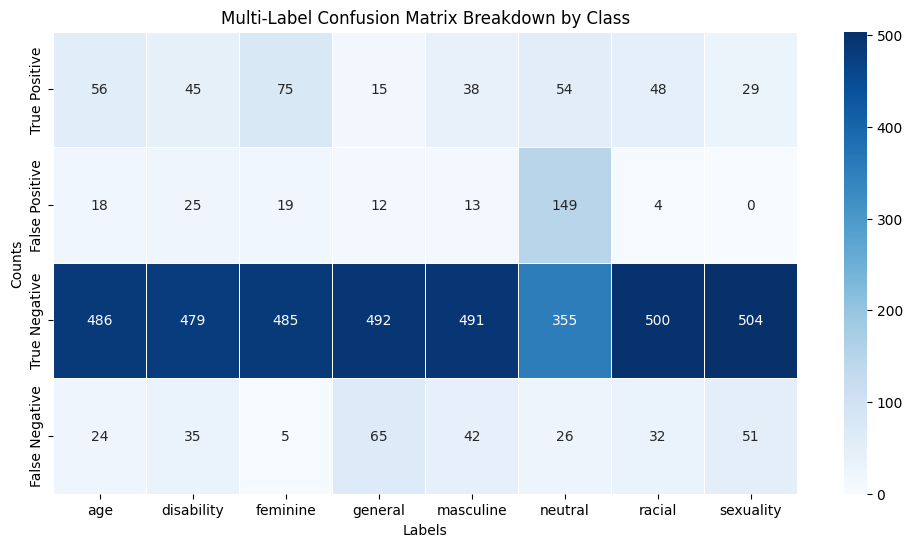

              precision    recall  f1-score   support

         age       0.76      0.70      0.73        80
  disability       0.64      0.56      0.60        80
    feminine       0.80      0.94      0.86        80
     general       0.56      0.19      0.28        80
   masculine       0.75      0.47      0.58        80
     neutral       0.27      0.68      0.38        80
      racial       0.92      0.60      0.73        80
   sexuality       1.00      0.36      0.53        80

   micro avg       0.60      0.56      0.58       640
   macro avg       0.71      0.56      0.59       640
weighted avg       0.71      0.56      0.59       640
 samples avg       0.61      0.59      0.59       640



In [13]:
# Merge all chunk results into a single file
all_results = []
for chunk_index in range(len(chunks)):
    with open(f'chunk_{chunk_index}_results.json', 'r') as f:
        chunk_results = json.load(f)
        all_results.extend(chunk_results)

# Save all results to a final JSON file
with open('all_results.json', 'w') as f:
    json.dump(all_results, f)

print(all_results)

#Extract labels
predictions, not_parsed = responses_to_predictions(all_results)

print(f"Num not parsed: {len(not_parsed)}")

#There still may be a few unparseable responses. Remove these from the ground truth labels
truth_labels = data_to_test['labels']
filtered_truth_labels = [label for idx, label in enumerate(truth_labels) if idx not in not_parsed]

metrics = compute_metrics(predictions, filtered_truth_labels)
print_metrics(metrics)

tp, fp, tn, fn = calculate_counts(np.array(filtered_truth_labels), np.array(predictions))
heatmap_TP_FP_TN_FN(tp, fp, tn, fn)

print(classification_report(filtered_truth_labels, predictions, target_names=labels))